In [26]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from numpy import concatenate
from scipy.stats import randint
from datetime import datetime
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
from matplotlib import pyplot # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [5]:
# load data
def parse(x):
    return datetime.strptime(x, '%d/%m/%Y %H')
bike = pd.read_csv("SeoulBikeData.csv", encoding ="unicode_escape",
                 parse_dates = [['Date', 'Hour']], 
                 index_col = 0, date_parser = parse)
# manually specify column names
bike.columns = ["BikeCount",
                "Temperature", "Humidity",
                "WindSpeed", "Visibility",
                "Dewpoint", "SolarRadiation",
                "Rainfall", "Snowfall",
                "Seasons", "Holiday", "FunctionalDay"]
bike.index.name = "Datetime"
print(bike.head())
# save to file
bike.to_csv('SeoulBikeData2.csv')

                     BikeCount  Temperature  Humidity  WindSpeed  Visibility  \
Datetime                                                                       
2017-12-01 00:00:00        254         -5.2        37        2.2        2000   
2017-12-01 01:00:00        204         -5.5        38        0.8        2000   
2017-12-01 02:00:00        173         -6.0        39        1.0        2000   
2017-12-01 03:00:00        107         -6.2        40        0.9        2000   
2017-12-01 04:00:00         78         -6.0        36        2.3        2000   

                     Dewpoint  SolarRadiation  Rainfall  Snowfall Seasons  \
Datetime                                                                    
2017-12-01 00:00:00     -17.6             0.0       0.0       0.0  Winter   
2017-12-01 01:00:00     -17.6             0.0       0.0       0.0  Winter   
2017-12-01 02:00:00     -17.7             0.0       0.0       0.0  Winter   
2017-12-01 03:00:00     -17.6             0.0       0.

# Multivariate LSTM Forecast Model
## LSTM Data Preparation:
1. We will frame the supervised learning problem as predicting the bike demand at the current hour (t) given the bike demand and weather conditions at the prior time step.
2. Normalize the input variables



In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

We can see the 12 input variables (input series) and the 1 output variable (bike demand at the current hour).

Some to-do:
* One-hot encoding categorical variables.
* Making all series stationary with differencing and seasonal adjustment.
* Providing more than 1 hour of input time steps.

In [18]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# load dataset
dataset = read_csv('SeoulBikeData2.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# LabelEncoder() only takes a 1-d array as an argument ,may be a better way the encode
encoder = LabelEncoder()
values[:,9] = encoder.fit_transform(values[:,9])
values[:,10] = encoder.fit_transform(values[:,10])
values[:,11] = encoder.fit_transform(values[:,11])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[13,14,15,16,17,18,19,20,21,22,23]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.071429   0.220280   0.377551   0.297297        1.0   0.224914   
2   0.057368   0.215035   0.387755   0.108108        1.0   0.224914   
3   0.048650   0.206294   0.397959   0.135135        1.0   0.223183   
4   0.030090   0.202797   0.408163   0.121622        1.0   0.224914   
5   0.021935   0.206294   0.367347   0.310811        1.0   0.207612   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0        0.0        0.0         1.0         1.0         1.0   
2        0.0        0.0        0.0         1.0         1.0         1.0   
3        0.0        0.0        0.0         1.0         1.0         1.0   
4        0.0        0.0        0.0         1.0         1.0         1.0   
5        0.0        0.0        0.0         1.0         1.0         1.0   

    var1(t)  
1  0.057368  
2  0.048650  
3  0.030090  
4  0.021935  
5  0.028121  


## Define and Fit Model

In [41]:
# split into train and test sets
values = reframed.values
days_for_cv = 50
N = sum(1 for row in bike)
n_train_hours = (N - days_for_cv * 24 )
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7571, 1, 12) (7571,) (1188, 1, 12) (1188,)


### Model architecture
1) LSTM with 50 neurons in the first visible layer

2) dropout 20% >>>> not sure yet

3) 1 neuron in the output layer for predicting Bike Demand.

4) The input shape will be 1 time step with 12 features.

5) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

6) The model will be fit for 20 training epochs with a batch size of 70.

Epoch 1/50
106/106 - 2s - loss: 0.0938 - val_loss: 0.0775 - 2s/epoch - 23ms/step
Epoch 2/50
106/106 - 0s - loss: 0.0715 - val_loss: 0.0561 - 206ms/epoch - 2ms/step
Epoch 3/50
106/106 - 0s - loss: 0.0488 - val_loss: 0.0501 - 201ms/epoch - 2ms/step
Epoch 4/50
106/106 - 0s - loss: 0.0456 - val_loss: 0.0495 - 218ms/epoch - 2ms/step
Epoch 5/50
106/106 - 0s - loss: 0.0448 - val_loss: 0.0494 - 219ms/epoch - 2ms/step
Epoch 6/50
106/106 - 0s - loss: 0.0442 - val_loss: 0.0495 - 209ms/epoch - 2ms/step
Epoch 7/50
106/106 - 0s - loss: 0.0438 - val_loss: 0.0505 - 219ms/epoch - 2ms/step
Epoch 8/50
106/106 - 0s - loss: 0.0436 - val_loss: 0.0498 - 232ms/epoch - 2ms/step
Epoch 9/50
106/106 - 0s - loss: 0.0437 - val_loss: 0.0505 - 261ms/epoch - 2ms/step
Epoch 10/50
106/106 - 0s - loss: 0.0433 - val_loss: 0.0503 - 204ms/epoch - 2ms/step
Epoch 11/50
106/106 - 0s - loss: 0.0431 - val_loss: 0.0510 - 207ms/epoch - 2ms/step
Epoch 12/50
106/106 - 0s - loss: 0.0430 - val_loss: 0.0510 - 220ms/epoch - 2ms/step
Epo

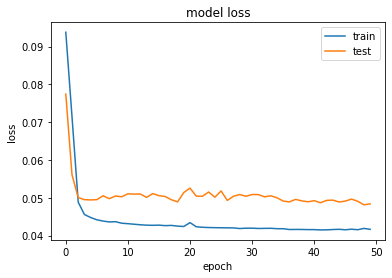

In [42]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# summarize history for loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend()
pyplot.show()

In [44]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 293.297
